In [1]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict, OrderedDict
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 15,  # 默认字体大小
        "axes.titlesize": 17,  # 标题字体
        "axes.labelsize": 15,  # 坐标轴标签
        "xtick.labelsize": 13,  # x 轴刻度
        "ytick.labelsize": 13,  # y 轴刻度
        "legend.fontsize": 13,  # 图例字体
    }
)

In [3]:
CREDENTIALS_JSON = "../rm4mt-463314-3ce1280ee29c.json"
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
]

In [4]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}

In [5]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing


In [6]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(
                r"(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$",
                ws_name,
            )
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {"model", "lang_pair"}.issubset(df.columns):
                continue
            # Budget Column
            budget_cols = [
                col
                for col in df.columns
                if isinstance(col, (int, float))
                or (isinstance(col, str) and col.isdigit())
            ]
            budget_cols = sorted(budget_cols, key=lambda x: int(x))
            for _, row in df.iterrows():
                model = row["model"]
                lang_pair = row["lang_pair"]
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    dfs_by_metric[metric].append(
                        {
                            "model": model,
                            "task": task,
                            "metric": metric,
                            "lang_pair": lang_pair,
                            "budget": int(budget),
                            "score": float(val),
                        }
                    )

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric


dfs_by_metric = split_by_metric(all_data)

In [7]:
dfs_by_metric.keys()

dict_keys(['comet_score', 'comet_kiwi_score', 'grb', 'grf', 'gea_100', 'gea_5', 'thinking_length'])

In [8]:
gea_100_df = dfs_by_metric["gea_100"]
drt_gea_100_df = gea_100_df[
    (gea_100_df["lang_pair"] == "Avg")
    & (gea_100_df["model"].isin(["DRT-7B", "DRT-8B", "DRT-14B"]))
    # & (gea_100_df["task"] == "DRT-Gutenberg")
]
drt_gea_100_df.rename(columns={"budget": "budget_tokens"}, inplace=True)
drt_gea_100_df.head()

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\2045675082.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drt_gea_100_df.rename(columns={"budget": "budget_tokens"}, inplace=True)


,model,task,metric,lang_pair,budget_tokens,score
0,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,100,67.936847
1,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,200,69.901818
2,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,300,68.965728
3,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,400,73.829469
4,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,500,74.652344


In [ ]:
gea_5_df = dfs_by_metric["gea_5"]
drt_gea_5_df = gea_5_df[
    (gea_5_df["lang_pair"] == "Avg")
    & (gea_5_df["model"].isin(["DRT-7B", "DRT-8B", "DRT-14B"]))
    # & (gea_5_df["task"] == "DRT-Gutenberg")
]
drt_gea_5_df.rename(columns={"budget": "budget_tokens"}, inplace=True)
drt_gea_5_df.head()

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\2607809157.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drt_gea_5_df.rename(columns={"budget": "budget_tokens"}, inplace=True)


,model,task,metric,lang_pair,budget_tokens,score
0,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,100,3.422641
1,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,200,3.449829
2,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,300,3.367932
3,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,400,3.431217
4,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,500,3.576795


In [40]:
grb_df = dfs_by_metric["grb"]
drt_grb_df = grb_df[
    (grb_df["lang_pair"] == "Avg")
    & (grb_df["model"].isin(["DRT-7B", "DRT-8B", "DRT-14B"]))
    & (grb_df["task"] != "WMT23-Biomedical-Sentence")
    & (grb_df["task"].isin(["DRT-Gutenberg", "LITEVAL-CORPUS", "WMT-Literary"]))
]
drt_grb_df.rename(columns={"budget": "budget_tokens"}, inplace=True)
drt_grb_df.head()

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\2016857286.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drt_grb_df.rename(columns={"budget": "budget_tokens"}, inplace=True)


,model,task,metric,lang_pair,budget_tokens,score
1445,DRT-14B,LITEVAL-CORPUS,grb,Avg,100,78.523861
1446,DRT-14B,LITEVAL-CORPUS,grb,Avg,200,76.989012
1447,DRT-14B,LITEVAL-CORPUS,grb,Avg,300,74.298040
1448,DRT-14B,LITEVAL-CORPUS,grb,Avg,400,73.734458
1449,DRT-14B,LITEVAL-CORPUS,grb,Avg,500,74.110449


In [41]:
grf_df = dfs_by_metric["grf"]
drt_grf_df = grf_df[
    (grf_df["lang_pair"] == "Avg")
    & (grf_df["model"].isin(["DRT-7B", "DRT-8B", "DRT-14B"]))
    & (grb_df["task"] != "WMT23-Biomedical-Sentence")
    & (grf_df["task"].isin(["DRT-Gutenberg", "LITEVAL-CORPUS", "WMT-Literary"]))
]
drt_grf_df.rename(columns={"budget": "budget_tokens"}, inplace=True)
drt_grf_df.head()

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4019988504.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drt_grf_df.rename(columns={"budget": "budget_tokens"}, inplace=True)


,model,task,metric,lang_pair,budget_tokens,score
1445,DRT-14B,LITEVAL-CORPUS,grf,Avg,100,75.178158
1446,DRT-14B,LITEVAL-CORPUS,grf,Avg,200,75.883007
1447,DRT-14B,LITEVAL-CORPUS,grf,Avg,300,73.993038
1448,DRT-14B,LITEVAL-CORPUS,grf,Avg,400,72.161125
1449,DRT-14B,LITEVAL-CORPUS,grf,Avg,500,74.126871


In [42]:
tokens_df = dfs_by_metric["thinking_length"]
drt_tokens_df = tokens_df[
    (tokens_df["lang_pair"] == "Avg")
    & (tokens_df["model"].isin(["DRT-7B", "DRT-8B", "DRT-14B"]))
    # & (tokens_df["task"] == "DRT-Gutenberg")
]
drt_tokens_df.rename(columns={"budget": "budget_tokens"}, inplace=True)
drt_tokens_df.rename(columns={"score": "actual_tokens"}, inplace=True)
drt_tokens_df.head()

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\2398952302.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drt_tokens_df.rename(columns={"budget": "budget_tokens"}, inplace=True)
C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\2398952302.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drt_tokens_df.rename(columns={"score": "actual_tokens"}, inplace=True)


,model,task,metric,lang_pair,budget_tokens,actual_tokens
0,DRT-14B,WMT23-Biomedical-Doc,thinking_length,Avg,100,99.753177
1,DRT-14B,WMT23-Biomedical-Doc,thinking_length,Avg,200,204.328582
2,DRT-14B,WMT23-Biomedical-Doc,thinking_length,Avg,300,299.562828
3,DRT-14B,WMT23-Biomedical-Doc,thinking_length,Avg,400,395.402826
4,DRT-14B,WMT23-Biomedical-Doc,thinking_length,Avg,500,488.668773


In [11]:
def plot_budget_actual_score(
    drt_gea_100_df: pd.DataFrame,
    drt_tokens_df: pd.DataFrame,
    metric_name: str,
    save_path: str = None,
):
    """
    Faceted twin-axis plot per task:
      - x: budget_tokens
      - left y: actual_tokens (solid line, with y=x ideal line)
      - right y: GEA_100 score (dashed line)
      - color: model
      - marker: distinguish models (o / s / ^)
    """

    # ---- 1) 预处理 ----
    key_cols = ["model", "task", "lang_pair", "budget_tokens"]
    score_df = drt_gea_100_df.copy()
    score_df = score_df[key_cols + ["score"]].rename(columns={"score": "gea100_score"})
    tok_df = drt_tokens_df.copy()
    tok_df = tok_df[key_cols + ["actual_tokens"]]

    merged = pd.merge(score_df, tok_df, on=key_cols, how="inner")
    merged["budget_tokens"] = merged["budget_tokens"].astype(int)
    merged["actual_tokens"] = merged["actual_tokens"].astype(float)
    merged["gea100_score"] = merged["gea100_score"].astype(float)

    model_order = ["DRT-7B", "DRT-8B", "DRT-14B"]
    present_models = [m for m in model_order if m in merged["model"].unique()]
    for m in merged["model"].unique():
        if m not in present_models:
            present_models.append(m)

    tasks = list(OrderedDict.fromkeys(merged["task"]))

    color_map = {
        "DRT-7B": "tab:blue",
        "DRT-8B": "tab:orange",
        "DRT-14B": "tab:green",
    }
    marker_map = {
        "DRT-7B": "o",  # 圆点
        "DRT-8B": "s",  # 方块
        "DRT-14B": "^",  # 三角
    }

    def get_color(m):
        return color_map.get(m, None)

    def get_marker(m):
        return marker_map.get(m, "o")

    # ---- 2) 画布布局 ----
    n_tasks = len(tasks)
    ncols = 3
    nrows = (n_tasks + ncols - 1) // ncols
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(5 * ncols, 4.2 * nrows), sharey=False
    )
    if nrows * ncols > 1:
        axes = np.array(axes).reshape(-1)
    else:
        axes = np.array([axes])

    # xticks = sorted(merged["budget_tokens"].unique().tolist())
    xticks = [100, 500, 1000, 2000]
    model_handles = OrderedDict()

    # ---- 3) 分面绘图 ----
    for i, task in enumerate(tasks):
        ax_left = axes[i]
        sub = merged[merged["task"] == task].copy()

        # 左轴 actual_tokens
        for m in present_models:
            ms = sub[sub["model"] == m].sort_values("budget_tokens")
            if ms.empty:
                continue
            h_left = ax_left.plot(
                ms["budget_tokens"],
                ms["actual_tokens"],
                marker=get_marker(m),
                linestyle="-",
                linewidth=1.5,
                label=m,
                color=get_color(m),
            )[0]
            if m not in model_handles:
                model_handles[m] = h_left

        # 理想线 y=x
        bx_min, bx_max = min(xticks), max(xticks)
        ax_left.plot(
            [bx_min, bx_max],
            [bx_min, bx_max],
            linestyle="--",
            linewidth=1.0,
            color="gray",
            alpha=0.7,
        )

        if task == "DRT-Gutenberg":
            ax_left.set_title("MetaphorTrans")
        elif task == "LITEVAL-CORPUS":
            ax_left.set_title("LitEval-Corpus")
        elif task == "WMT-Literary":
            ax_left.set_title("WMT24-Literary")
        else:
            ax_left.set_title(task)
        ax_left.set_xlabel("")
        ax_left.set_ylabel("")
        ax_left.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
        ax_left.set_xticks(xticks)

        # 右轴 gea100_score
        ax_right = ax_left.twinx()
        for m in present_models:
            ms = sub[sub["model"] == m].sort_values("budget_tokens")
            if ms.empty:
                continue
            ax_right.plot(
                ms["budget_tokens"],
                ms["gea100_score"],
                marker=get_marker(m),
                linestyle="--",
                linewidth=1.5,
                label=f"{m} (score)",
                color=get_color(m),
                alpha=0.9,
            )
        ax_right.tick_params(axis="y", which="both", direction="out")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # ---- 4) 全局标签与图例 ----
    # fig.supxlabel("Thinking Budget (tokens)", fontsize=13, y=0.03)
    fig.text(0.5, 0.01, "Thinking Budget (Tokens)", ha="center", fontsize=14)
    fig.supylabel(
        f"Actual Tokens (left) / {metric_name} Score (right)", fontsize=14, x=0.055
    )

    # 1) 模型图例（颜色+marker）
    model_order_fixed = ["DRT-7B", "DRT-8B", "DRT-14B"]  # 想固定顺序就用这行
    model_handles_ordered = [model_handles[m] for m in model_order_fixed if m in model_handles]
    model_labels_ordered  = [m for m in model_order_fixed if m in model_handles]

    from matplotlib.lines import Line2D

    style_handles = [
        Line2D(
            [0], [0], color="black", linestyle="-", marker="o", label="Actual tokens"
        ),
        Line2D(
            [0],
            [0],
            color="black",
            linestyle="--",
            marker="o",
            label=f"{metric_name} score",
        ),
        Line2D([0], [0], color="gray", linestyle="--", label="Ideal y = x"),
    ]
    style_labels = [h.get_label() for h in style_handles]

    # 3) 为了保证“两行对齐”，长度不同则用“空句柄”补齐
    L = max(len(model_handles_ordered), len(style_handles))
    blank = Line2D([], [], linestyle="None", marker="", alpha=0)  # 空白占位
    while len(model_handles_ordered) < L:
        model_handles_ordered.append(blank); model_labels_ordered.append("")
    while len(style_handles) < L:
        style_handles.append(blank); style_labels.append("")

    # 4) 交错排列：M1,S1, M2,S2, M3,S3
    interleaved_handles = [h for pair in zip(model_handles_ordered, style_handles) for h in pair]
    interleaved_labels  = [l for pair in zip(model_labels_ordered,  style_labels)  for l in pair]

    # 5) 画一个合并 legend（两行；第一行全是模型，第二行全是样式）
    fig.legend(
        interleaved_handles,
        interleaved_labels,
        loc="lower right",
        bbox_to_anchor=(0.99, -0.06),
        ncol=L,  # 列数=每行的项目数（这里=模型个数）
        frameon=True,
    )

    fig.tight_layout(rect=[0.04, 0.08, 1, 0.97])

    if save_path:
        plt.savefig(save_path, dpi=900, bbox_inches="tight")
    plt.show()

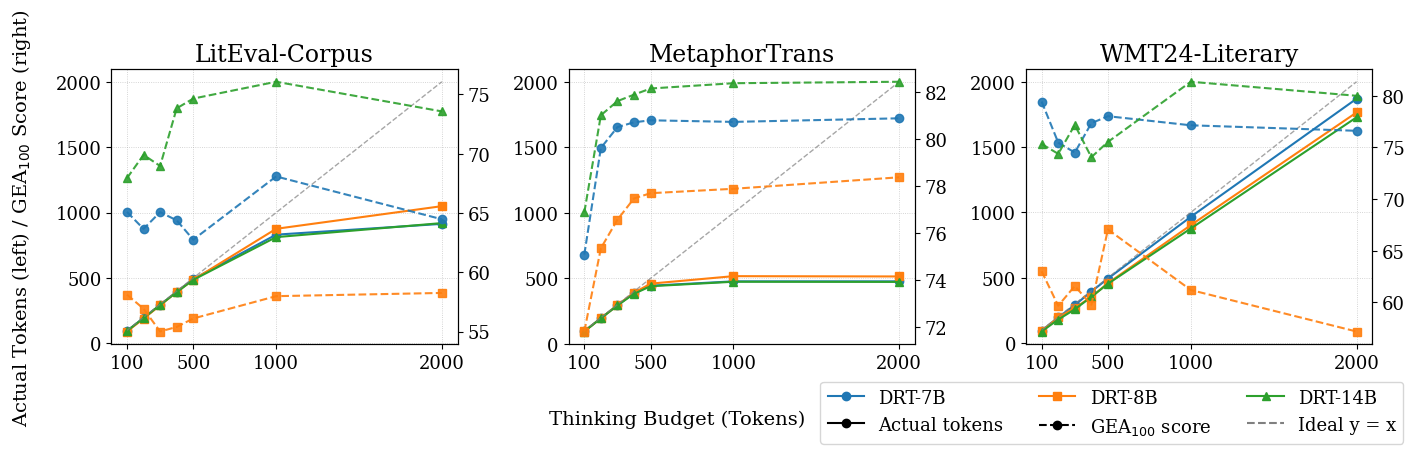

In [12]:
plot_budget_actual_score(
    drt_gea_100_df,
    drt_tokens_df,
    r"GEA$_{100}$",
    # save_path="budget_actual_gea100_facets.png",
    save_path="budget_actual_gea100_facets.pdf",
)

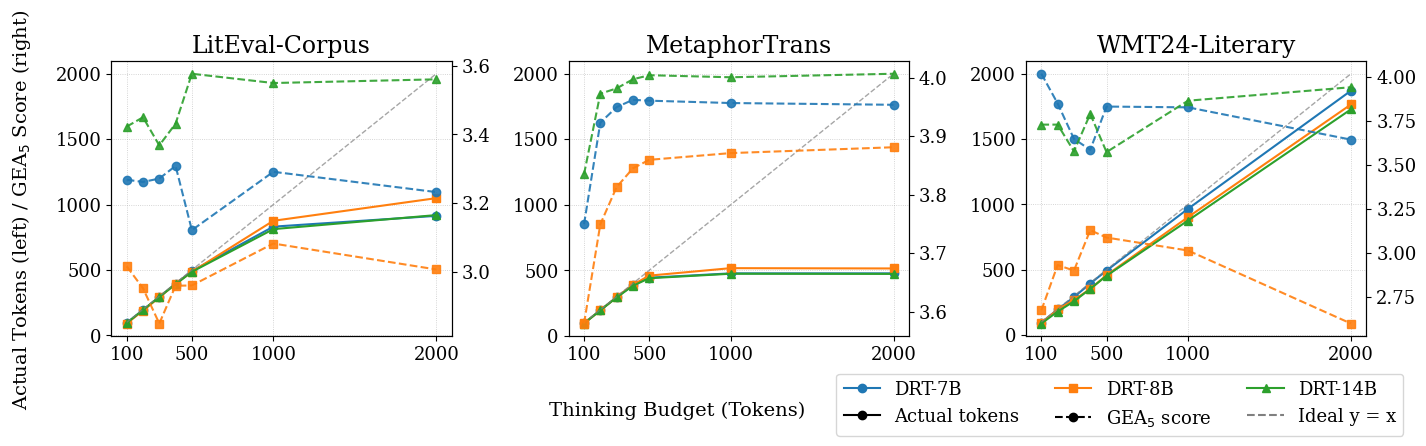

In [13]:
plot_budget_actual_score(
    drt_gea_5_df,
    drt_tokens_df,
    r"GEA$_{5}$",
    # save_path="budget_actual_gea5_facets.png",
    save_path="budget_actual_gea5_facets.pdf",
)

In [14]:
def plot_budget_actual_score_vertical(
    drt_gea_100_df: pd.DataFrame,
    drt_tokens_df: pd.DataFrame,
    metric_name: str,
    save_path: str = None,
):
    """
    Faceted twin-axis plot per task (vertical layout):
      - x: budget_tokens
      - left y: actual_tokens (solid line, with y=x ideal line)
      - right y: GEA_100 score (dashed line)
      - color: model
      - marker: distinguish models (o / s / ^)
    """

    # ---- 1) 预处理 ----
    key_cols = ["model", "task", "lang_pair", "budget_tokens"]
    score_df = drt_gea_100_df.copy()
    score_df = score_df[key_cols + ["score"]].rename(columns={"score": "gea100_score"})
    tok_df = drt_tokens_df.copy()
    tok_df = tok_df[key_cols + ["actual_tokens"]]

    merged = pd.merge(score_df, tok_df, on=key_cols, how="inner")
    merged["budget_tokens"] = merged["budget_tokens"].astype(int)
    merged["actual_tokens"] = merged["actual_tokens"].astype(float)
    merged["gea100_score"] = merged["gea100_score"].astype(float)

    model_order = ["DRT-7B", "DRT-8B", "DRT-14B"]
    present_models = [m for m in model_order if m in merged["model"].unique()]
    for m in merged["model"].unique():
        if m not in present_models:
            present_models.append(m)

    tasks = list(OrderedDict.fromkeys(merged["task"]))

    color_map = {
        "DRT-7B": "tab:blue",
        "DRT-8B": "tab:orange",
        "DRT-14B": "tab:green",
    }
    marker_map = {"DRT-7B": "o", "DRT-8B": "s", "DRT-14B": "^"}

    def get_color(m):
        return color_map.get(m, None)

    def get_marker(m):
        return marker_map.get(m, "o")

    # ---- 2) 画布布局 (竖向) ----
    n_tasks = len(tasks)
    ncols = 1
    nrows = n_tasks
    fig, axes = plt.subplots(nrows, ncols, figsize=(6, 4.2 * nrows), sharey=False)
    if nrows > 1:
        axes = np.array(axes).reshape(-1)
    else:
        axes = np.array([axes])

    xticks = [100, 500, 1000, 2000]
    model_handles = OrderedDict()

    # ---- 3) 分面绘图 ----
    for i, task in enumerate(tasks):
        ax_left = axes[i]
        sub = merged[merged["task"] == task].copy()

        for m in present_models:
            ms = sub[sub["model"] == m].sort_values("budget_tokens")
            if ms.empty:
                continue
            h_left = ax_left.plot(
                ms["budget_tokens"],
                ms["actual_tokens"],
                marker=get_marker(m),
                linestyle="-",
                linewidth=1.5,
                label=m,
                color=get_color(m),
            )[0]
            if m not in model_handles:
                model_handles[m] = h_left

        bx_min, bx_max = min(xticks), max(xticks)
        ax_left.plot(
            [bx_min, bx_max],
            [bx_min, bx_max],
            linestyle="--",
            linewidth=1.0,
            color="gray",
            alpha=0.7,
        )

        if task == "DRT-Gutenberg":
            ax_left.set_title("MetaphorTrans")
        elif task == "LITEVAL-CORPUS":
            ax_left.set_title("LitEval-Corpus")
        elif task == "WMT-Literary":
            ax_left.set_title("WMT24-Literary")
        else:
            ax_left.set_title(task)

        if i == 2:
            ax_left.set_xlabel("Thinking Budget (Tokens)")
        if i == 1:
            ax_left.set_ylabel("Actual Tokens")
        ax_left.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
        ax_left.set_xticks(xticks)

        ax_right = ax_left.twinx()
        for m in present_models:
            ms = sub[sub["model"] == m].sort_values("budget_tokens")
            if ms.empty:
                continue
            ax_right.plot(
                ms["budget_tokens"],
                ms["gea100_score"],
                marker=get_marker(m),
                linestyle="--",
                linewidth=1.5,
                label=f"{m} (score)",
                color=get_color(m),
                alpha=0.9,
            )
        if i == 1:
            ax_right.set_ylabel(f"{metric_name} Score")

    # ---- 4) Legend ----
    model_order_fixed = ["DRT-7B", "DRT-8B", "DRT-14B"]
    model_handles_ordered = [
        model_handles[m] for m in model_order_fixed if m in model_handles
    ]
    model_labels_ordered = [m for m in model_order_fixed if m in model_handles]

    from matplotlib.lines import Line2D

    style_handles = [
        Line2D(
            [0], [0], color="black", linestyle="-", marker="o", label="Actual tokens"
        ),
        Line2D(
            [0],
            [0],
            color="black",
            linestyle="--",
            marker="o",
            label=f"{metric_name} score",
        ),
        Line2D([0], [0], color="gray", linestyle="--", label="Ideal y = x"),
    ]
    style_labels = [h.get_label() for h in style_handles]

    L = max(len(model_handles_ordered), len(style_handles))
    blank = Line2D([], [], linestyle="None", marker="", alpha=0)
    while len(model_handles_ordered) < L:
        model_handles_ordered.append(blank)
        model_labels_ordered.append("")
    while len(style_handles) < L:
        style_handles.append(blank)
        style_labels.append("")

    interleaved_handles = [
        h for pair in zip(model_handles_ordered, style_handles) for h in pair
    ]
    interleaved_labels = [
        l for pair in zip(model_labels_ordered, style_labels) for l in pair
    ]

    fig.legend(
        interleaved_handles,
        interleaved_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        ncol=L,
        frameon=True,
    )

    fig.tight_layout(rect=[0.05, 0.05, 1, 0.97])

    if save_path:
        plt.savefig(save_path, dpi=900, bbox_inches="tight")
    plt.show()

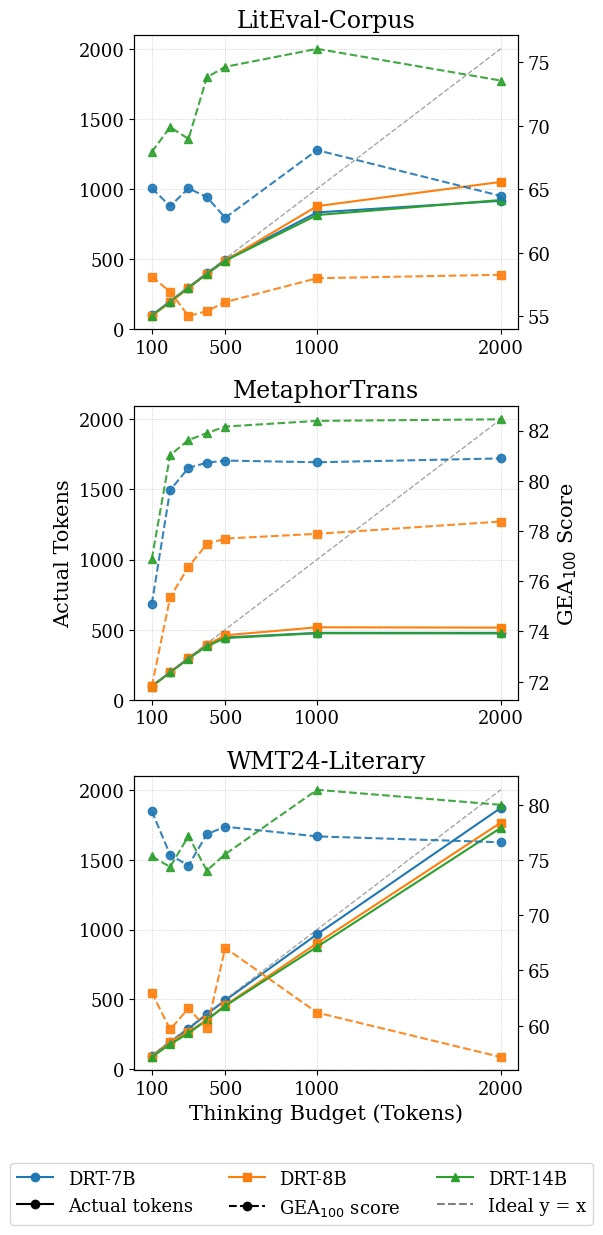

In [ ]:
plot_budget_actual_score_vertical(
    drt_gea_100_df,
    drt_tokens_df,
    r"GEA$_{100}$",
    save_path="budget_actual_gea100_facets_vertical.pdf",
)

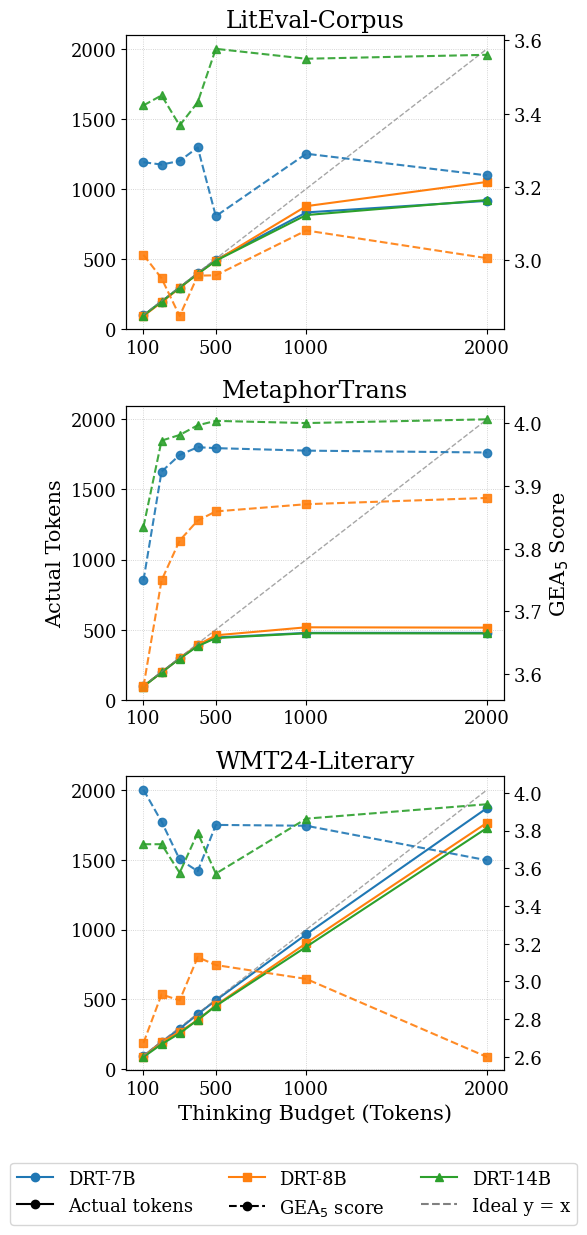

In [16]:
plot_budget_actual_score_vertical(
    drt_gea_5_df,
    drt_tokens_df,
    r"GEA$_{5}$",
    save_path="budget_actual_gea5_facets_vertical.pdf",
)

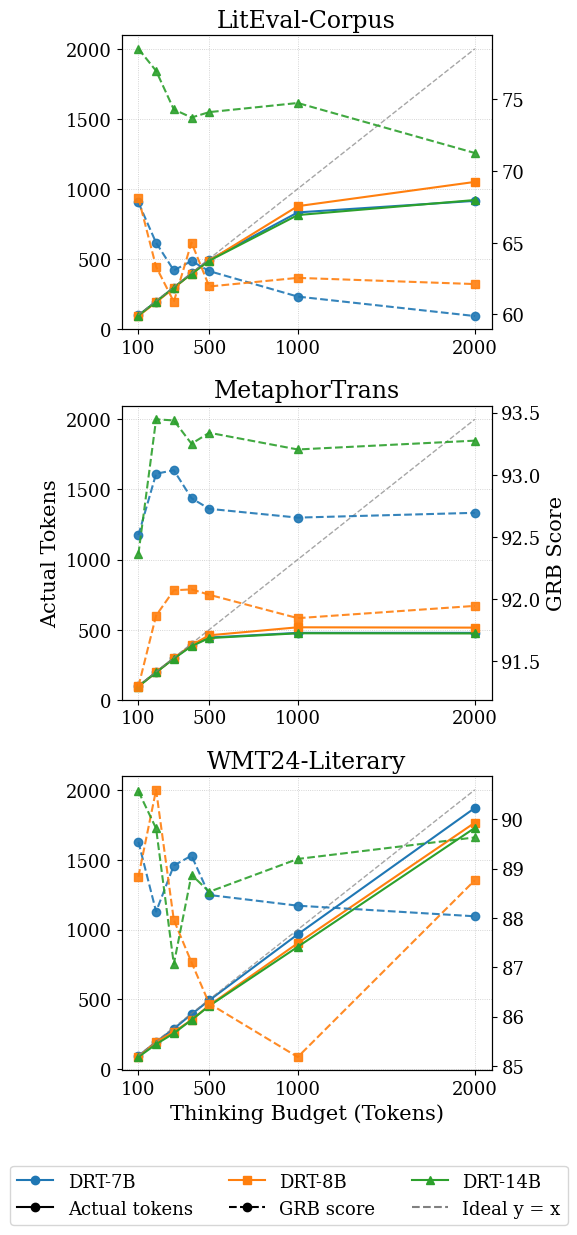

In [43]:
plot_budget_actual_score_vertical(
    drt_grb_df,
    drt_tokens_df,
    r"GRB",
    save_path="budget_actual_grb_facets_vertical.pdf",
)

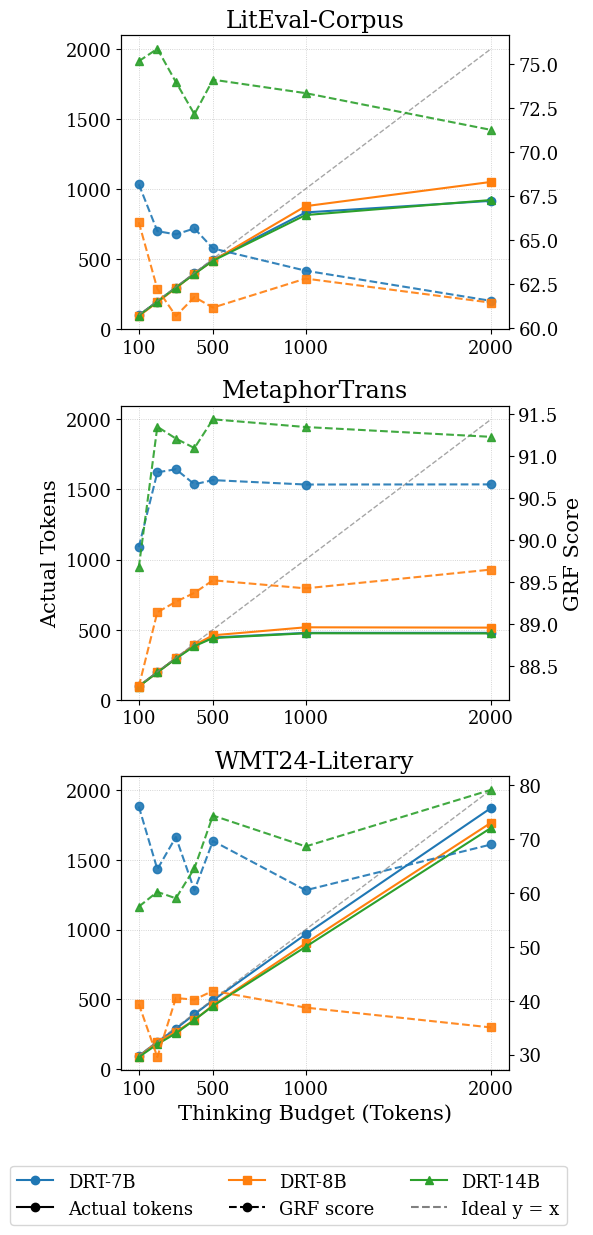

In [44]:
plot_budget_actual_score_vertical(
    drt_grf_df,
    drt_tokens_df,
    r"GRF",
    save_path="budget_actual_grf_facets_vertical.pdf",
)

In [17]:
def plot_budget_actual_score_combined(
    drt_gea_100_df: pd.DataFrame,
    drt_gea_5_df: pd.DataFrame,
    drt_tokens_df: pd.DataFrame,
    save_path: str = None,
):
    """
    Combined vertical facets (3 rows) × 2 columns:
      - Left col: GEA_100
      - Right col: GEA_5
      - Only one global legend
    """

    key_cols = ["model", "task", "lang_pair", "budget_tokens"]

    def prepare(df, tok_df, score_col):
        score_df = df.copy()[key_cols + ["score"]].rename(columns={"score": score_col})
        tok_df = tok_df.copy()[key_cols + ["actual_tokens"]]
        merged = pd.merge(score_df, tok_df, on=key_cols, how="inner")
        merged["budget_tokens"] = merged["budget_tokens"].astype(int)
        merged["actual_tokens"] = merged["actual_tokens"].astype(float)
        merged[score_col] = merged[score_col].astype(float)
        return merged

    merged100 = prepare(drt_gea_100_df, drt_tokens_df, "gea100_score")
    merged5 = prepare(drt_gea_5_df, drt_tokens_df, "gea5_score")

    tasks = list(OrderedDict.fromkeys(merged100["task"]))  # 两个数据集 task 相同
    model_order = ["DRT-7B", "DRT-8B", "DRT-14B"]
    color_map = {"DRT-7B": "tab:blue", "DRT-8B": "tab:orange", "DRT-14B": "tab:green"}
    marker_map = {"DRT-7B": "o", "DRT-8B": "s", "DRT-14B": "^"}
    xticks = [100, 500, 1000, 2000]

    fig, axes = plt.subplots(
        nrows=len(tasks), ncols=2, figsize=(12, 4.2 * len(tasks)), sharey=False
    )

    model_handles = OrderedDict()

    for row, task in enumerate(tasks):
        for col, (merged, score_col, metric_name) in enumerate(
            [
                (merged100, "gea100_score", r"GEA$_{100}$"),
                (merged5, "gea5_score", r"GEA$_{5}$"),
            ]
        ):
            ax_left = axes[row, col]
            sub = merged[merged["task"] == task].copy()

            # Actual tokens
            for m in model_order:
                ms = sub[sub["model"] == m].sort_values("budget_tokens")
                if ms.empty:
                    continue
                h_left = ax_left.plot(
                    ms["budget_tokens"],
                    ms["actual_tokens"],
                    marker=marker_map.get(m, "o"),
                    linestyle="-",
                    linewidth=1.5,
                    label=m,
                    color=color_map.get(m, None),
                )[0]
                if m not in model_handles:
                    model_handles[m] = h_left

            ax_left.plot(
                [min(xticks), max(xticks)],
                [min(xticks), max(xticks)],
                linestyle="--",
                linewidth=1.0,
                color="gray",
                alpha=0.7,
            )

            # Titles
            if task == "DRT-Gutenberg":
                ax_left.set_title(f"MetaphorTrans ({metric_name})")
            elif task == "LITEVAL-CORPUS":
                ax_left.set_title(f"LitEval-Corpus ({metric_name})")
            elif task == "WMT-Literary":
                ax_left.set_title(f"WMT24-Literary ({metric_name})")
            else:
                ax_left.set_title(f"{task} ({metric_name})")

            if row == len(tasks) - 1:
                ax_left.set_xlabel("Thinking Budget (Tokens)")
            if col == 0 and row == 1:
                ax_left.set_ylabel("Actual Tokens")
            ax_left.set_xticks(xticks)
            ax_left.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

            # Right axis
            ax_right = ax_left.twinx()
            for m in model_order:
                ms = sub[sub["model"] == m].sort_values("budget_tokens")
                if ms.empty:
                    continue
                ax_right.plot(
                    ms["budget_tokens"],
                    ms[score_col],
                    marker=marker_map.get(m, "o"),
                    linestyle="--",
                    linewidth=1.5,
                    label=f"{m} (score)",
                    color=color_map.get(m, None),
                    alpha=0.9,
                )
            if col == 1 and row == 1:
                ax_right.set_ylabel("Score")

    # ---- Legend (全局) ----
    from matplotlib.lines import Line2D

    model_order_fixed = ["DRT-7B", "DRT-8B", "DRT-14B"]
    model_handles_ordered = [
        model_handles[m] for m in model_order_fixed if m in model_handles
    ]
    model_labels_ordered = [m for m in model_order_fixed if m in model_handles]

    style_handles = [
        Line2D(
            [0], [0], color="black", linestyle="-", marker="o", label="Actual tokens"
        ),
        Line2D([0], [0], color="black", linestyle="--", marker="o", label="Score"),
        Line2D([0], [0], color="gray", linestyle="--", label="Ideal y = x"),
    ]
    style_labels = [h.get_label() for h in style_handles]

    fig.legend(
        model_handles_ordered + style_handles,
        model_labels_ordered + style_labels,
        loc="lower center",
        bbox_to_anchor=(0.54, -0.01),
        ncol=len(model_order_fixed) + len(style_handles),
        frameon=True,
    )

    fig.tight_layout(rect=[0.05, 0.05, 1, 0.97])
    if save_path:
        plt.savefig(save_path, dpi=900, bbox_inches="tight")
    plt.show()

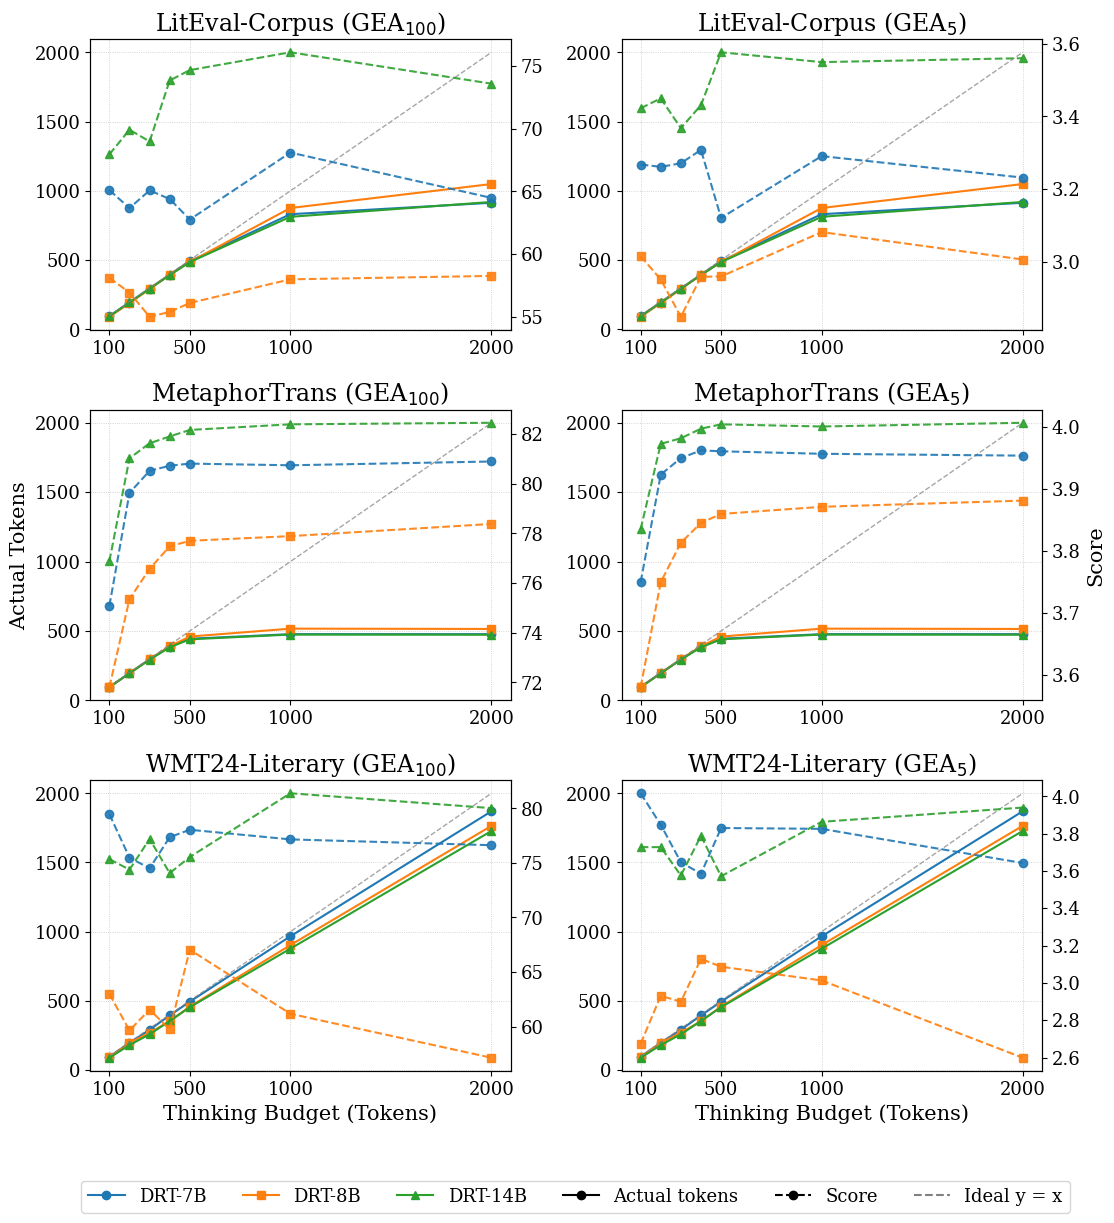

In [18]:
plot_budget_actual_score_combined(
    drt_gea_100_df,
    drt_gea_5_df,
    drt_tokens_df,
    save_path="budget_actual_combined.pdf",
)

In [47]:
def plot_budget_actual_score_grb_grf_combined(
    drt_grb_df: pd.DataFrame,
    drt_grf_df: pd.DataFrame,
    drt_tokens_df: pd.DataFrame,
    save_path: str = None,
):
    """
    Combined vertical facets (3 rows) × 2 columns:
      - Left col: GRB
      - Right col: GRF
      - Only one global legend
    """

    key_cols = ["model", "task", "lang_pair", "budget_tokens"]

    def prepare(df, tok_df, score_col):
        score_df = df.copy()[key_cols + ["score"]].rename(columns={"score": score_col})
        tok_df = tok_df.copy()[key_cols + ["actual_tokens"]]
        merged = pd.merge(score_df, tok_df, on=key_cols, how="inner")
        merged["budget_tokens"] = merged["budget_tokens"].astype(int)
        merged["actual_tokens"] = merged["actual_tokens"].astype(float)
        merged[score_col] = merged[score_col].astype(float)
        return merged

    merged_grb = prepare(drt_grb_df, drt_tokens_df, "grb_score")
    merged_grf = prepare(drt_grf_df, drt_tokens_df, "grf_score")

    tasks = list(OrderedDict.fromkeys(merged_grb["task"]))  # 两个数据集 task 相同
    model_order = ["DRT-7B", "DRT-8B", "DRT-14B"]
    color_map = {"DRT-7B": "tab:blue", "DRT-8B": "tab:orange", "DRT-14B": "tab:green"}
    marker_map = {"DRT-7B": "o", "DRT-8B": "s", "DRT-14B": "^"}
    xticks = [100, 500, 1000, 2000]

    fig, axes = plt.subplots(
        nrows=len(tasks), ncols=2, figsize=(12, 4.2 * len(tasks)), sharey=False
    )

    model_handles = OrderedDict()

    for row, task in enumerate(tasks):
        for col, (merged, score_col, metric_name) in enumerate(
            [
                (merged_grb, "grb_score", r"GRB"),
                (merged_grf, "grf_score", r"GRF"),
            ]
        ):
            ax_left = axes[row, col]
            sub = merged[merged["task"] == task].copy()

            # Actual tokens
            for m in model_order:
                ms = sub[sub["model"] == m].sort_values("budget_tokens")
                if ms.empty:
                    continue
                h_left = ax_left.plot(
                    ms["budget_tokens"],
                    ms["actual_tokens"],
                    marker=marker_map.get(m, "o"),
                    linestyle="-",
                    linewidth=1.5,
                    label=m,
                    color=color_map.get(m, None),
                )[0]
                if m not in model_handles:
                    model_handles[m] = h_left

            ax_left.plot(
                [min(xticks), max(xticks)],
                [min(xticks), max(xticks)],
                linestyle="--",
                linewidth=1.0,
                color="gray",
                alpha=0.7,
            )

            # Titles
            if task == "DRT-Gutenberg":
                ax_left.set_title(f"MetaphorTrans ({metric_name})")
            elif task == "LITEVAL-CORPUS":
                ax_left.set_title(f"LitEval-Corpus ({metric_name})")
            elif task == "WMT-Literary":
                ax_left.set_title(f"WMT24-Literary ({metric_name})")
            else:
                ax_left.set_title(f"{task} ({metric_name})")

            if row == len(tasks) - 1:
                ax_left.set_xlabel("Thinking Budget (Tokens)")
            if col == 0 and row == 1:
                ax_left.set_ylabel("Actual Tokens")
            ax_left.set_xticks(xticks)
            ax_left.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

            # Right axis
            ax_right = ax_left.twinx()
            for m in model_order:
                ms = sub[sub["model"] == m].sort_values("budget_tokens")
                if ms.empty:
                    continue
                ax_right.plot(
                    ms["budget_tokens"],
                    ms[score_col],
                    marker=marker_map.get(m, "o"),
                    linestyle="--",
                    linewidth=1.5,
                    label=f"{m} (score)",
                    color=color_map.get(m, None),
                    alpha=0.9,
                )
            if col == 1 and row == 1:
                ax_right.set_ylabel("Score")

    # ---- Legend (全局) ----
    from matplotlib.lines import Line2D

    model_order_fixed = ["DRT-7B", "DRT-8B", "DRT-14B"]
    model_handles_ordered = [
        model_handles[m] for m in model_order_fixed if m in model_handles
    ]
    model_labels_ordered = [m for m in model_order_fixed if m in model_handles]

    style_handles = [
        Line2D(
            [0], [0], color="black", linestyle="-", marker="o", label="Actual tokens"
        ),
        Line2D([0], [0], color="black", linestyle="--", marker="o", label="Score"),
        Line2D([0], [0], color="gray", linestyle="--", label="Ideal y = x"),
    ]
    style_labels = [h.get_label() for h in style_handles]

    fig.legend(
        model_handles_ordered + style_handles,
        model_labels_ordered + style_labels,
        loc="lower center",
        bbox_to_anchor=(0.54, -0.01),
        ncol=len(model_order_fixed) + len(style_handles),
        frameon=True,
    )

    fig.tight_layout(rect=[0.05, 0.05, 1, 0.97])
    if save_path:
        plt.savefig(save_path, dpi=900, bbox_inches="tight")
    plt.show()

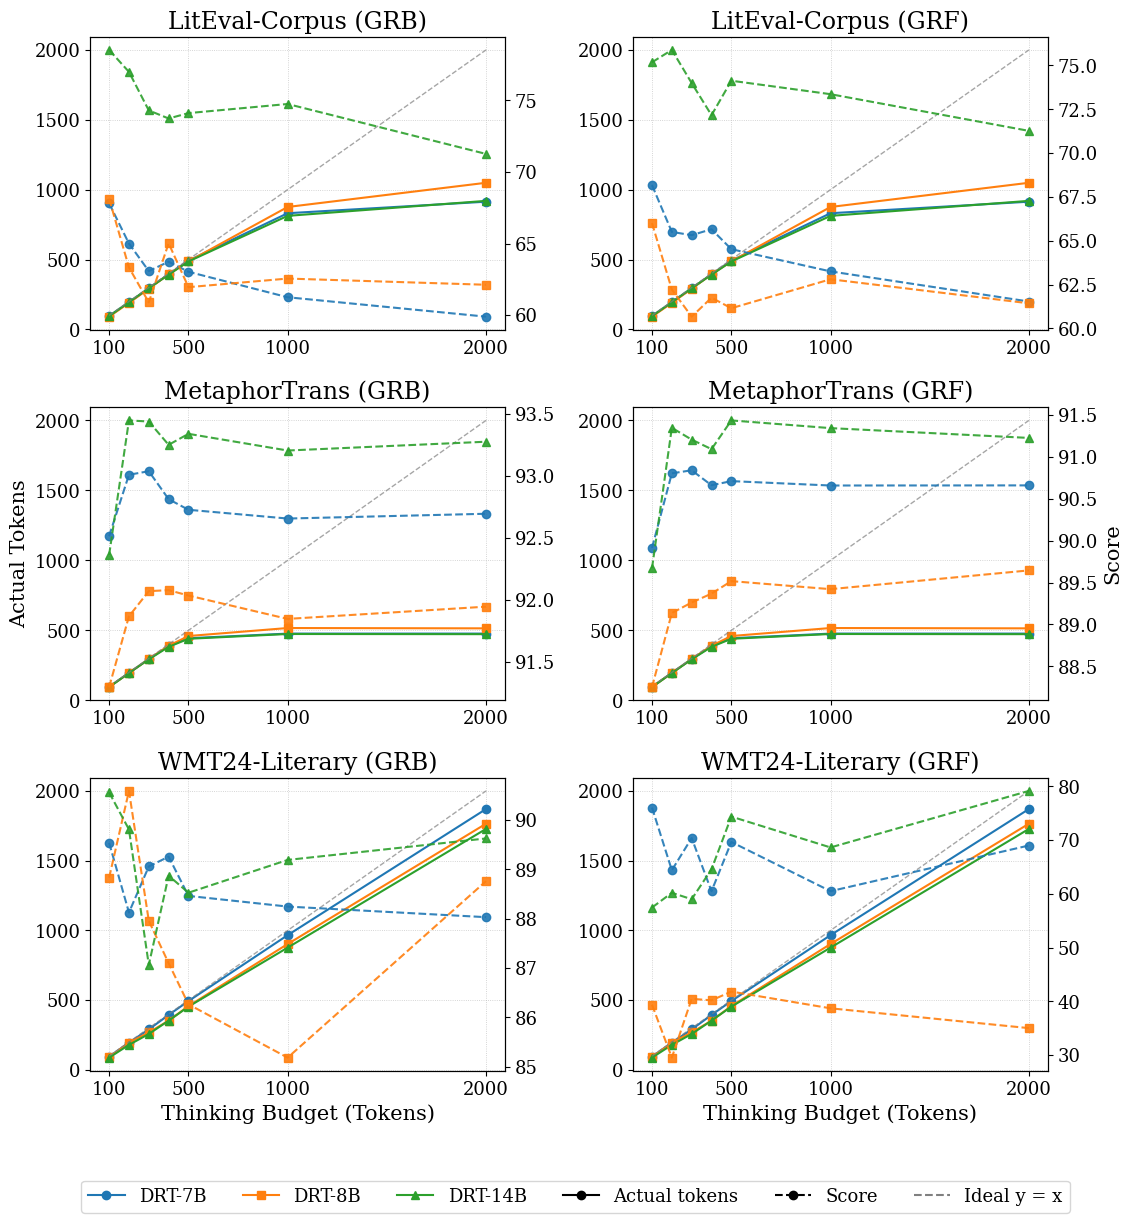

In [49]:
plot_budget_actual_score_grb_grf_combined(
    drt_grb_df,
    drt_grf_df,
    drt_tokens_df,
    save_path="budget_actual_grb_grf_combined.pdf",
)

In [19]:
import pandas as pd


def latex_table_budget_as_columns(
    df: pd.DataFrame,
    budgets_order=(100, 200, 300, 400, 500, 1000, 2000),
    models_order=("DRT-8B", "DRT-14B", "DRT-32B"),
    float_digits=2,
    caption="GEA$_{100}$ scores across tasks, models, and thinking budgets",
    label="tab:gea100_budget_columns",
    table_star=True,
):
    if "score" in df.columns:
        use = df[["task", "model", "budget_tokens", "score"]].copy()
    else:
        use = df[["task", "model", "budget_tokens", "actual_tokens"]].copy()

    # 排序
    budgets = [b for b in budgets_order if b in use["budget_tokens"].unique().tolist()]
    use["budget_tokens"] = pd.Categorical(
        use["budget_tokens"], categories=budgets, ordered=True
    )
    use["model"] = pd.Categorical(use["model"], categories=models_order, ordered=True)

    # pivot: 行 = (task, model)，列 = budget
    if "score" in df.columns:
        wide = use.pivot_table(
            index=["task", "model"], columns="budget_tokens", values="score", aggfunc="mean"
        ).sort_index()
    else:
        wide = use.pivot_table(
            index=["task", "model"], columns="budget_tokens", values="actual_tokens", aggfunc="mean"
        ).sort_index()

    # 格式化
    fmt = f"{{:.{float_digits}f}}"
    wide_fmt = wide.applymap(lambda x: fmt.format(x) if pd.notnull(x) else "--")

    env = "table*" if table_star else "table"
    latex = []
    latex += [f"\\begin{{{env}}}[t]"]
    latex += [r"\centering"]
    latex += [r"\resizebox{\textwidth}{!}{%"]
    latex += [r"\begin{tabular}{l l " + " ".join(["c"] * len(budgets)) + r"}"]
    latex += [r"\toprule"]

    # 表头
    latex += ["Task & Model & " + " & ".join([f"Budget={b}" for b in budgets]) + r" \\"]
    latex += [r"\midrule"]

    # 内容
    for (task, model), row in wide_fmt.iterrows():
        latex.append(f"{task} & {model} & " + " & ".join(row.tolist()) + r" \\")

    latex += [r"\bottomrule"]
    latex += [r"\end{tabular}}"]
    latex += [f"\\caption{{{caption}}}"]
    latex += [f"\\label{{{label}}}"]
    latex += [f"\\end{{{env}}}"]

    return "\n".join(latex)


In [20]:
latex_code = latex_table_budget_as_columns(
    drt_gea_100_df,
    budgets_order=(100, 200, 300, 400, 500, 1000, 2000),
    models_order=("DRT-7B", "DRT-8B", "DRT-14B"),
    float_digits=2,
    caption="GEA$_{100}$ across tasks and models with budgets as columns",
    label="tab:gea100_budget_columns",
    table_star=True,
)

print(latex_code)

\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c c c}
\toprule
Task & Model & Budget=100 & Budget=200 & Budget=300 & Budget=400 & Budget=500 & Budget=1000 & Budget=2000 \\
\midrule
DRT-Gutenberg & DRT-7B & 75.08 & 79.63 & 80.52 & 80.72 & 80.81 & 80.74 & 80.89 \\
DRT-Gutenberg & DRT-8B & 71.81 & 75.36 & 76.57 & 77.48 & 77.70 & 77.89 & 78.38 \\
DRT-Gutenberg & DRT-14B & 76.88 & 81.02 & 81.62 & 81.90 & 82.16 & 82.39 & 82.45 \\
LITEVAL-CORPUS & DRT-7B & 65.09 & 63.66 & 65.07 & 64.38 & 62.75 & 68.08 & 64.47 \\
LITEVAL-CORPUS & DRT-8B & 58.11 & 56.92 & 55.00 & 55.39 & 56.10 & 57.98 & 58.26 \\
LITEVAL-CORPUS & DRT-14B & 67.94 & 69.90 & 68.97 & 73.83 & 74.65 & 76.07 & 73.57 \\
WMT-Literary & DRT-7B & 79.45 & 75.48 & 74.50 & 77.35 & 78.03 & 77.15 & 76.62 \\
WMT-Literary & DRT-8B & 63.00 & 59.66 & 61.57 & 59.75 & 67.05 & 61.18 & 57.16 \\
WMT-Literary & DRT-14B & 75.34 & 74.38 & 77.18 & 74.06 & 75.54 & 81.37 & 80.01 \\
\bottomrule
\end{tabular}}
\caption{GEA$

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = use.pivot_table(
C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide_fmt = wide.applymap(lambda x: fmt.format(x) if pd.notnull(x) else "--")


In [21]:
latex_code = latex_table_budget_as_columns(
    drt_gea_5_df,
    budgets_order=(100, 200, 300, 400, 500, 1000, 2000),
    models_order=("DRT-7B", "DRT-8B", "DRT-14B"),
    float_digits=2,
    caption="GEA$_{5}$ across tasks and models with budgets as columns",
    label="tab:gea100_budget_columns",
    table_star=True,
)

print(latex_code)

\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c c c}
\toprule
Task & Model & Budget=100 & Budget=200 & Budget=300 & Budget=400 & Budget=500 & Budget=1000 & Budget=2000 \\
\midrule
DRT-Gutenberg & DRT-7B & 3.75 & 3.92 & 3.95 & 3.96 & 3.96 & 3.96 & 3.95 \\
DRT-Gutenberg & DRT-8B & 3.58 & 3.75 & 3.81 & 3.85 & 3.86 & 3.87 & 3.88 \\
DRT-Gutenberg & DRT-14B & 3.83 & 3.97 & 3.98 & 4.00 & 4.00 & 4.00 & 4.01 \\
LITEVAL-CORPUS & DRT-7B & 3.27 & 3.26 & 3.27 & 3.31 & 3.12 & 3.29 & 3.23 \\
LITEVAL-CORPUS & DRT-8B & 3.02 & 2.95 & 2.85 & 2.96 & 2.96 & 3.08 & 3.01 \\
LITEVAL-CORPUS & DRT-14B & 3.42 & 3.45 & 3.37 & 3.43 & 3.58 & 3.55 & 3.56 \\
WMT-Literary & DRT-7B & 4.02 & 3.85 & 3.65 & 3.58 & 3.83 & 3.83 & 3.64 \\
WMT-Literary & DRT-8B & 2.67 & 2.93 & 2.90 & 3.13 & 3.09 & 3.01 & 2.60 \\
WMT-Literary & DRT-14B & 3.73 & 3.73 & 3.58 & 3.79 & 3.57 & 3.86 & 3.94 \\
\bottomrule
\end{tabular}}
\caption{GEA$_{5}$ across tasks and models with budgets as columns}
\label{t

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = use.pivot_table(
C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide_fmt = wide.applymap(lambda x: fmt.format(x) if pd.notnull(x) else "--")


In [22]:
latex_code = latex_table_budget_as_columns(
    drt_tokens_df,
    budgets_order=(100, 200, 300, 400, 500, 1000, 2000),
    models_order=("DRT-7B", "DRT-8B", "DRT-14B"),
    float_digits=2,
    caption="Actual tokens across tasks and models with budgets as columns",
    label="tab:gea100_budget_columns",
    table_star=True,
)

print(latex_code)

\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c c c}
\toprule
Task & Model & Budget=100 & Budget=200 & Budget=300 & Budget=400 & Budget=500 & Budget=1000 & Budget=2000 \\
\midrule
CAMT & DRT-7B & 96.26 & 195.13 & 294.49 & 388.31 & 451.79 & 505.75 & 515.04 \\
CAMT & DRT-8B & 96.19 & 195.16 & 295.03 & 389.84 & 459.00 & 511.67 & 518.67 \\
CAMT & DRT-14B & 94.20 & 194.78 & 292.97 & 383.75 & 444.69 & 487.42 & 492.48 \\
CommonsenseMT-Contextless & DRT-7B & 95.94 & 195.55 & 289.94 & 342.42 & 358.89 & 352.20 & 352.20 \\
CommonsenseMT-Contextless & DRT-8B & 96.93 & 196.57 & 294.35 & 370.89 & 405.74 & 409.46 & 409.46 \\
CommonsenseMT-Contextless & DRT-14B & 97.20 & 194.83 & 288.11 & 339.82 & 356.21 & 361.26 & 361.26 \\
CommonsenseMT-Contextual & DRT-7B & 99.85 & 195.71 & 293.97 & 365.28 & 377.08 & 379.43 & 379.43 \\
CommonsenseMT-Contextual & DRT-8B & 96.93 & 196.77 & 295.53 & 378.98 & 411.21 & 407.90 & 407.90 \\
CommonsenseMT-Contextual & DRT-14B & 95.94 &

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:31: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = use.pivot_table(
C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide_fmt = wide.applymap(lambda x: fmt.format(x) if pd.notnull(x) else "--")


In [52]:
latex_code = latex_table_budget_as_columns(
    drt_grb_df,
    budgets_order=(100, 200, 300, 400, 500, 1000, 2000),
    models_order=("DRT-7B", "DRT-8B", "DRT-14B"),
    float_digits=2,
    caption="GRB across tasks and models with budgets as columns",
    label="tab:grb_budget_columns",
    table_star=True,
)

print(latex_code)

\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c c c}
\toprule
Task & Model & Budget=100 & Budget=200 & Budget=300 & Budget=400 & Budget=500 & Budget=1000 & Budget=2000 \\
\midrule
DRT-Gutenberg & DRT-7B & 92.51 & 93.01 & 93.04 & 92.81 & 92.73 & 92.66 & 92.69 \\
DRT-Gutenberg & DRT-8B & 91.30 & 91.87 & 92.07 & 92.08 & 92.04 & 91.85 & 91.95 \\
DRT-Gutenberg & DRT-14B & 92.36 & 93.45 & 93.44 & 93.25 & 93.34 & 93.20 & 93.27 \\
LITEVAL-CORPUS & DRT-7B & 67.81 & 65.00 & 63.08 & 63.73 & 63.02 & 61.25 & 59.89 \\
LITEVAL-CORPUS & DRT-8B & 68.13 & 63.33 & 60.89 & 65.02 & 61.95 & 62.55 & 62.12 \\
LITEVAL-CORPUS & DRT-14B & 78.52 & 76.99 & 74.30 & 73.73 & 74.11 & 74.75 & 71.26 \\
WMT-Literary & DRT-7B & 89.54 & 88.13 & 89.06 & 89.26 & 88.46 & 88.25 & 88.03 \\
WMT-Literary & DRT-8B & 88.83 & 90.59 & 87.96 & 87.10 & 86.26 & 85.18 & 88.76 \\
WMT-Literary & DRT-14B & 90.56 & 89.81 & 87.06 & 88.87 & 88.53 & 89.19 & 89.63 \\
\bottomrule
\end{tabular}}
\caption{GRB 

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = use.pivot_table(
C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide_fmt = wide.applymap(lambda x: fmt.format(x) if pd.notnull(x) else "--")


In [53]:
latex_code = latex_table_budget_as_columns(
    drt_grf_df,
    budgets_order=(100, 200, 300, 400, 500, 1000, 2000),
    models_order=("DRT-7B", "DRT-8B", "DRT-14B"),
    float_digits=2,
    caption="GRF across tasks and models with budgets as columns",
    label="tab:grf_budget_columns",
    table_star=True,
)

print(latex_code)

\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c c c}
\toprule
Task & Model & Budget=100 & Budget=200 & Budget=300 & Budget=400 & Budget=500 & Budget=1000 & Budget=2000 \\
\midrule
DRT-Gutenberg & DRT-7B & 89.91 & 90.81 & 90.84 & 90.66 & 90.71 & 90.66 & 90.66 \\
DRT-Gutenberg & DRT-8B & 88.25 & 89.14 & 89.26 & 89.37 & 89.52 & 89.42 & 89.65 \\
DRT-Gutenberg & DRT-14B & 89.67 & 91.35 & 91.21 & 91.09 & 91.44 & 91.34 & 91.23 \\
LITEVAL-CORPUS & DRT-7B & 68.17 & 65.50 & 65.32 & 65.66 & 64.52 & 63.25 & 61.53 \\
LITEVAL-CORPUS & DRT-8B & 66.01 & 62.22 & 60.67 & 61.75 & 61.15 & 62.80 & 61.43 \\
LITEVAL-CORPUS & DRT-14B & 75.18 & 75.88 & 73.99 & 72.16 & 74.13 & 73.36 & 71.27 \\
WMT-Literary & DRT-7B & 76.06 & 64.40 & 70.39 & 60.50 & 69.66 & 60.51 & 69.00 \\
WMT-Literary & DRT-8B & 39.38 & 29.54 & 40.48 & 40.19 & 41.83 & 38.72 & 35.03 \\
WMT-Literary & DRT-14B & 57.46 & 60.20 & 59.01 & 64.58 & 74.38 & 68.64 & 79.16 \\
\bottomrule
\end{tabular}}
\caption{GRF 

C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = use.pivot_table(
C:\Users\zihao\AppData\Local\Temp\ipykernel_19532\4197195003.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide_fmt = wide.applymap(lambda x: fmt.format(x) if pd.notnull(x) else "--")
